In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt
import maup
import requests

**Census voting districts shapefile**

In [2]:
import os
os.getcwd()

'/Users/lilyfalk/Github/pdv-mi/mggg-mi'

In [3]:
#https://catalog.data.gov/dataset/tiger-line-shapefile-2012-2010-state-michigan-2010-census-voting-district-state-based-vtd
vtd = gpd.read_file("tl_2012_26_vtd10/tl_2012_26_vtd10.shp")

**Census block shapefile**

In [4]:
blocks = gpd.read_file("tl_2017_26_tabblock10/tl_2017_26_tabblock10.shp")

**Block-level demographic data**

In [5]:
#code chunk by Melisande Teng 

variables = [
    # pop
    "P001001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    "P005011",
    "P005012",
    "P005013",
    "P005014",
    "P005015",
    "P005016",
    "P005017",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN ",
    "NH_ASIAN",
    "NH_NHPI ",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    "H_WHITE",
    "H_BLACK",
    "H_AMIN ",
    "H_ASIAN",
    "H_NHPI ",
    "H_OTHER",
    "H_2MORE",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]


def counties(state_fips):
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes

def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [6]:
demographic = block_data_for_state('26') # For MI onlyb


**2016 Voting Precincts**

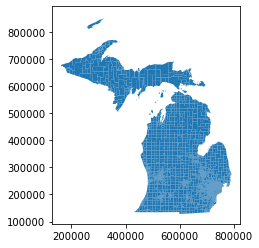

In [13]:
precincts = gpd.read_file("2016_Voting_Precincts-shp/2016_Voting_Precincts.shp")
precincts.plot()

In [14]:
precincts.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20..."
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20..."
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20..."
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20..."


In [15]:
precincts.nunique()

OBJECTID      4810
Id            4769
VTD2016       4810
CountyFips      83
Jurisdicti    1520
ElectionYe       1
Label         1306
ShapeSTAre    4810
ShapeSTLen    4810
geometry      4810
dtype: int64

In [18]:
election.shape

(8146112, 37)

In [29]:
df = elect_pivoted
gdf = precincts

In [32]:
df.head()

,PRES16D,PRES16G,PRES16L,PRES16R
precinct,,,,
ACME TOWNSHIP; 1,556.222222,51.500000,57.444444,854.444444
ACME TOWNSHIP; 2,254.666667,15.166667,29.444444,564.000000
ADA TOWNSHIP; 1,268.000000,16.142857,23.111111,492.333333
ADA TOWNSHIP; 2,536.222222,25.000000,50.333333,895.000000
ADA TOWNSHIP; 3,266.888889,18.857143,29.777778,574.888889


In [34]:
df.shape

(4795, 4)

In [33]:
gdf.head()

,OBJECTID,Id,VTD2016,CountyFips,Jurisdicti,ElectionYe,Label,ShapeSTAre,ShapeSTLen,geometry
0,1,3888,1632100000001,163,21000,2016,City of Dearborn,2.489738e+06,6846.254657,"POLYGON ((734740.564 203392.197, 734729.230 20..."
1,2,3889,1632100000002,163,21000,2016,City of Dearborn,1.058362e+06,4621.388992,"POLYGON ((733757.240 203553.421, 733767.280 20..."
2,3,3890,1632100000003,163,21000,2016,City of Dearborn,1.488846e+06,4909.715171,"POLYGON ((733220.680 203094.269, 733125.455 20..."
3,4,3891,1632100000004,163,21000,2016,City of Dearborn,1.187165e+06,4354.743602,"POLYGON ((732401.480 203234.816, 732303.854 20..."
4,5,3892,1632100000005,163,21000,2016,City of Dearborn,1.133548e+06,5460.202887,"POLYGON ((731590.226 203387.835, 731604.080 20..."


In [41]:
gdf.Label.nunique()

1306

In [42]:
gdf.VTD2016.nunique()

4810

The scale of the precinct shapefile does not match that of other shapefiles in used in this script. Rescaling the precinct shapefile may result in the loss of important geographic features. Therefore, the script does not merge precinct-level election data with block-level demographic data and state house & senate districts.

In [43]:
election.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

**State house and Senate districts**

In [16]:
# State House
state_house = gpd.read_file("tl_2011_26_sldl/tl_2011_26_sldl.shp")

# State Senate
state_senate = gpd.read_file("tl_2011_26_sldu/tl_2011_26_sldu.shp")

In [17]:
state_house.head()

,STATEFP,SLDLST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,26,098,26098,State House District 98,LL,2010,G5220,N,1112688263,20224890,+43.4119307,-084.2345730,"POLYGON ((-83.97394 43.52329, -83.96779 43.523..."
1,26,094,26094,State House District 94,LL,2010,G5220,N,982458210,19105502,+43.3030887,-083.9582146,"POLYGON ((-84.17061 43.45253, -84.17061 43.462..."
2,26,095,26095,State House District 95,LL,2010,G5220,N,292245702,9872663,+43.3895144,-083.9174552,"POLYGON ((-83.81667 43.34949, -83.81666 43.349..."
3,26,080,26080,State House District 80,LL,2010,G5220,N,1756368818,3819297751,+42.2806954,-086.3376517,"POLYGON ((-85.99596 42.41897, -85.99465 42.418..."
4,26,081,26081,State House District 81,LL,2010,G5220,N,1433103685,284194383,+42.9909507,-082.8390301,"POLYGON ((-82.41988 43.00231, -82.42273 43.000..."


In [9]:
state_senate.head()

,STATEFP,SLDUST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,26,032,26032,State Senate District 32,LU,2010,G5210,N,3544598561,49207378,+43.3144336,-084.2815131,"POLYGON ((-83.97394 43.52329, -83.96779 43.523..."
1,26,021,26021,State Senate District 21,LU,2010,G5210,N,4132805449,3916054903,+42.0800198,-086.4581424,"POLYGON ((-85.96515 41.75996, -85.96795 41.759..."
2,26,020,26020,State Senate District 20,LU,2010,G5210,N,1634946080,54505667,+42.2411689,-085.5647665,"POLYGON ((-85.76400 42.13104, -85.76424 42.141..."
3,26,037,26037,State Senate District 37,LU,2010,G5210,N,14964533699,15423069409,+45.7073805,-084.6195485,"POLYGON ((-85.33291 44.79862, -85.33290 44.798..."
4,26,024,26024,State Senate District 24,LU,2010,G5210,N,5059533913,2683914021,+42.5984030,-085.8112138,"POLYGON ((-85.99465 42.41896, -85.99596 42.418..."


**2016 precinct-level election data**

In [7]:
pd.read_csv?

In [10]:
election.state_fips

0           1
1           1
2           1
3           1
4           1
           ..
8146107    54
8146108    54
8146109    54
8146110    54
8146111    54
Name: state_fips, Length: 8146112, dtype: int64

In [11]:
type(election.state_fips)

pandas.core.series.Series

In [20]:
election.columns

Index(['year', 'stage', 'special', 'state', 'state_postal', 'state_fips',
       'state_icpsr', 'county_name', 'county_fips', 'county_ansi',
       'county_lat', 'county_long', 'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes', 'candidate_opensecrets', 'candidate_wikidata',
       'candidate_party', 'candidate_last', 'candidate_first',
       'candidate_middle', 'candidate_full', 'candidate_suffix',
       'candidate_nickname', 'candidate_fec', 'candidate_fec_name',
       'candidate_google', 'candidate_govtrack', 'candidate_icpsr',
       'candidate_maplight'],
      dtype='object')

In [27]:
[x for x in election.office.unique() if '' in x.lower()]


['State Senate',
 'Amendment No. 5: Homestead Tax Exemption For Certain Senior, Low-Income, Long-Term Residents; Determination Of Just Value, Low-Income, Long-Term Residents; Determination Of Just Value',
 'Amendment No. 5: Homestead Tax Exemption For Certain Senior, Low-Income, Long-Term Residents; Determination Of Just Value',
 'SPECIAL TRANSPORTATION SERVICES FOR SENIOR CITIZENS AND PERSONS WITH DISABILITIES LEVY',
 'BOND QUESTION A: The 2016 Capital Projects General Obligation Bond Act authorizes the issuance and sale of senior citizen facility improvement, construction and equipment acquisition bonds. Shall the state be authorized to issue general obligation bonds in an amount not to exceed fifteen million four hundred forty thousand dollars ($15,440,000) to make capital expenditures for certain senior citizen facility improvement, construction and equipment acquisition projects and provide for a general property tax impos',
 '097: Increases corporate minimum tax when sales exceed

In [9]:
election = pd.read_csv("2016-precinct-state.csv", 
                       encoding='ISO-8859-1',
                       dtype = {"county_name" : "str",
                                "precinct" : "str",
                                "district" : "str"
                               })

election_MI = election[election.state_fips == 26]

# Filter out paties of interest
election_2016 = election_MI[
    (election_MI.party == 'democratic')|
    (election_MI.party == 'republican')|
    (election_MI.party == 'libertarian')|
    (election_MI.party == 'green')]

elect_pivoted = election_2016.pivot_table(index = ['precinct'], columns = ['party'], values = ['votes'])
elect_pivoted.columns = [' '.join(col).strip() for col in elect_pivoted.columns.values]
elect_pivoted.columns = ['PRES16D','PRES16G','PRES16L','PRES16R']

elect_pivoted.head()

,PRES16D,PRES16G,PRES16L,PRES16R
precinct,,,,
ACME TOWNSHIP; 1,556.222222,51.500000,57.444444,854.444444
ACME TOWNSHIP; 2,254.666667,15.166667,29.444444,564.000000
ADA TOWNSHIP; 1,268.000000,16.142857,23.111111,492.333333
ADA TOWNSHIP; 2,536.222222,25.000000,50.333333,895.000000
ADA TOWNSHIP; 3,266.888889,18.857143,29.777778,574.888889


In [28]:
elect_pivoted.shape

(4795, 4)

In [12]:
election.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
0,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,gen,False,Alabama,AL,1,41,Autauga County,1001.0,161526.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Join block shapefile and block-level demographic data**

In [22]:
blocks["geoid"] = blocks.GEOID10
block_demo = pd.merge(blocks, demographic, on='geoid', how='left', indicator=True)
#shapefile of blocks merging with demographic data based on the geoid 
block_demo = block_demo.drop(columns = "geoid")

In [25]:
# Check number of blocks after merging -- correct!
print(len(blocks.GEOID10))
print(len(block_demo.GEOID10))

329885
329885


In [ ]:
# Check total population after merging -- correct!
print(demographic.TOTPOP.sum())
print(block_demo.TOTPOP.sum())

In [23]:
block_demo.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,_merge
0,26,099,225200,2010,260992252002010,Block 2010,G5040,U,23824,U,...,0,0,0,1,"Block 2010, Block Group 2, Census Tract 2252, ...",26,099,225200,2010,both
1,26,099,222500,2004,260992225002004,Block 2004,G5040,U,23824,U,...,0,0,0,7,"Block 2004, Block Group 2, Census Tract 2225, ...",26,099,222500,2004,both
2,26,099,242000,2008,260992420002008,Block 2008,G5040,U,23824,U,...,2,0,0,0,"Block 2008, Block Group 2, Census Tract 2420, ...",26,099,242000,2008,both
3,26,099,227300,1006,260992273001006,Block 1006,G5040,U,23824,U,...,3,0,0,1,"Block 1006, Block Group 1, Census Tract 2273, ...",26,099,227300,1006,both
4,26,099,212000,1013,260992120001013,Block 1013,G5040,R,None,None,...,1,0,0,0,"Block 1013, Block Group 1, Census Tract 2120, ...",26,099,212000,1013,both


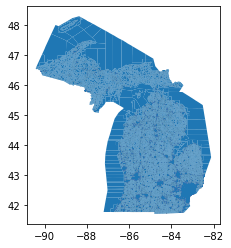

In [26]:
block_demo.plot()

**Aggregate block-level demographic shapefiles to voting districts**

In [27]:
proj =  {'init':'epsg:4326'}
block_demo.crs = proj
vtd.crs = proj

/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [28]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
pieces = maup.assign(block_demo, vtd)

/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/maup/intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/Users/lilyfalk/anaconda3/lib/python3.8/site-packages/maup/assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


In [18]:
vtd[keys] = block_demo[keys].astype(int).groupby(pieces).sum()

In [19]:
vtd.head()

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,...,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,26,059,110,26059110,A,0593848000001,Voting District 0593848000001,V1,G5240,N,...,2,1580,25,1527,7,6,7,0,0,8
1,26,059,200,26059200,A,0597198000001,Voting District 0597198000001,V1,G5240,N,...,4,1374,19,1330,3,9,2,0,0,11
2,26,059,10,2605910,A,0590030000001,Voting District 0590030000001,V1,G5240,N,...,2,1915,8,1871,8,7,6,0,0,15
3,26,059,170,26059170,A,0596712000001,Voting District 0596712000001,V1,G5240,N,...,3,694,11,680,0,1,1,0,0,1
4,26,059,50,2605950,A,0591278000001,Voting District 0591278000001,V1,G5240,N,...,0,1432,10,1412,2,2,1,0,0,5


In [20]:
# Check population
print(vtd.TOTPOP.sum())
print(block_demo.TOTPOP.sum())

9883640
9883640


**Assign State House and Senate districts**

In [21]:
state_house.crs = proj
state_house = state_house[{'SLDLST', 'geometry'}]
assignment = maup.assign(vtd, state_house)
vtd['HDIST'] = assignment.astype(int)
vtd.head()

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,HDIST
0,26,059,110,26059110,A,0593848000001,Voting District 0593848000001,V1,G5240,N,...,1580,25,1527,7,6,7,0,0,8,17
1,26,059,200,26059200,A,0597198000001,Voting District 0597198000001,V1,G5240,N,...,1374,19,1330,3,9,2,0,0,11,17
2,26,059,10,2605910,A,0590030000001,Voting District 0590030000001,V1,G5240,N,...,1915,8,1871,8,7,6,0,0,15,17
3,26,059,170,26059170,A,0596712000001,Voting District 0596712000001,V1,G5240,N,...,694,11,680,0,1,1,0,0,1,17
4,26,059,50,2605950,A,0591278000001,Voting District 0591278000001,V1,G5240,N,...,1432,10,1412,2,2,1,0,0,5,17


In [22]:
state_senate.crs = proj
state_senate = state_senate[{'SLDUST', 'geometry'}]
assignment = maup.assign(vtd, state_senate)
vtd['SENDIST'] = assignment.astype(int)
vtd.head()

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,...,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,HDIST,SENDIST
0,26,059,110,26059110,A,0593848000001,Voting District 0593848000001,V1,G5240,N,...,25,1527,7,6,7,0,0,8,17,6
1,26,059,200,26059200,A,0597198000001,Voting District 0597198000001,V1,G5240,N,...,19,1330,3,9,2,0,0,11,17,6
2,26,059,10,2605910,A,0590030000001,Voting District 0590030000001,V1,G5240,N,...,8,1871,8,7,6,0,0,15,17,6
3,26,059,170,26059170,A,0596712000001,Voting District 0596712000001,V1,G5240,N,...,11,680,0,1,1,0,0,1,17,6
4,26,059,50,2605950,A,0591278000001,Voting District 0591278000001,V1,G5240,N,...,10,1412,2,2,1,0,0,5,17,6


In [23]:
# Check state_house assignment
print(len(vtd.HDIST.unique()))
print(len(state_house.SLDLST.unique()))

110
110


In [24]:
# Check state_senate assignment
print(len(vtd.SENDIST.unique()))
print(len(state_senate.SLDUST.unique()))

38
38


In [25]:
vtd.columns

Index(['STATEFP10', 'COUNTYFP10', 'VTDST10', 'GEOID10', 'VTDI10', 'NAME10',
       'NAMELSAD10', 'LSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN ', 'NH_ASIAN', 'NH_NHPI ', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN ', 'H_ASIAN', 'H_NHPI ',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'HDIST', 'SENDIST'],
      dtype='object')

**Final mggg shapefile**

In [26]:
final = gpd.read_file("MI_precincts.shp")

In [27]:
final.head()

,VTD2016_x,ShapeSTLen,CountyFips,Jurisdicti,ElectionYe,Label,VTD,county_nam,county_fip,county_lat,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,HDIST,SENDIST,CD,geometry
0,0057498003002,1881.842376,005,74980,2016,City of South Haven,P0057498003002,Allegan County,26005,42.595787,...,4.919570e-08,0.000000e+00,0.0,0.0,0.0,0.000000e+00,080,026,06,"POLYGON ((-86.26019 42.41932, -86.26154 42.419..."
1,1632200004011,2707.392219,163,22000,2016,City of Detroit,P1632200004011,Wayne County,26163,42.284664,...,2.717738e-05,0.000000e+00,0.0,0.0,0.0,5.631869e-08,001,002,14,"POLYGON ((-82.94032 42.41407, -82.94125 42.413..."
2,1632200005454,3366.268244,163,22000,2016,City of Detroit,P1632200005454,Wayne County,26163,42.284664,...,5.970645e+00,2.917200e-11,0.0,0.0,0.0,1.591281e-07,005,004,13,"POLYGON ((-83.10155 42.35828, -83.10142 42.358..."
3,0636518000001,15685.809560,063,65180,2016,Pointe Aux Barques Township,P0636518000001,Huron County,26063,43.907616,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,084,025,10,"POLYGON ((-82.97992 44.05569, -82.97977 44.055..."
4,0715086000002,112221.960836,071,50860,2016,Mansfield Township,P0715086000002,Iron County,26071,46.170254,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,110,038,01,"POLYGON ((-88.21608 46.18757, -88.21630 46.187..."


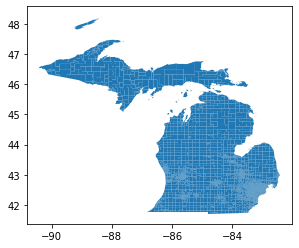

In [28]:
final.plot()

In [29]:
# remove zero-population area
vtd = vtd[vtd.TOTPOP != 0]

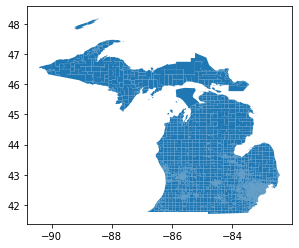

In [30]:
vtd.plot()

**Verification**

In [31]:
final['NAME10'] = final['VTD2016_x']
validate = pd.merge(vtd, final, on='NAME10', how="inner", indicator=True)

In [32]:
validate.columns

Index(['STATEFP10', 'COUNTYFP10', 'VTDST10', 'GEOID10', 'VTDI10', 'NAME10',
       'NAMELSAD10', 'LSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry_x', 'TOTPOP_x', 'NH_WHITE_x',
       'NH_BLACK_x', 'NH_AMIN ', 'NH_ASIAN_x', 'NH_NHPI ', 'NH_OTHER_x',
       'NH_2MORE', 'HISP_x', 'H_WHITE_x', 'H_BLACK_x', 'H_AMIN ', 'H_ASIAN_x',
       'H_NHPI ', 'H_OTHER_x', 'H_2MORE', 'VAP_x', 'HVAP_x', 'WVAP_x',
       'BVAP_x', 'AMINVAP_x', 'ASIANVAP_x', 'NHPIVAP_x', 'OTHERVAP_x',
       '2MOREVAP_x', 'HDIST_x', 'SENDIST_x', 'VTD2016_x', 'ShapeSTLen',
       'CountyFips', 'Jurisdicti', 'ElectionYe', 'Label', 'VTD', 'county_nam',
       'county_fip', 'county_lat', 'county_lon', 'jurisdic_1', 'precinct',
       'PRES16D', 'PRES16R', 'PRES16L', 'PRES16G', 'TOTPOP_y', 'NH_WHITE_y',
       'NH_BLACK_y', 'NH_AMIN', 'NH_ASIAN_y', 'NH_NHPI', 'NH_OTHER_y',
       'HISP_y', 'H_WHITE_y', 'H_BLACK_y', 'H_AMIN', 'H_ASIAN_y', 'H_NHPI',
       'H_OTHER_y', 'VAP_y

In [33]:
# Total population doesn't match exactly 
print(vtd.TOTPOP.sum())
print(final.TOTPOP.sum())
print(vtd.TOTPOP.sum()*100/final.TOTPOP.sum(), "%")

9883640
10132164.947459279
97.54716836186526 %


In [34]:
# 70% of districts have within 100 people difference in total population -- this is not a great result
validate["popdiff"] = abs(validate.TOTPOP_x - validate.TOTPOP_y)
print(len(validate[validate.popdiff <= 100])/len(validate.VTD2016_x.unique())*100, "%")

69.93736951983298 %
